**Import Libraries**

In [35]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from IPython.display import FileLink
from IPython.display import display
import re
from geopy.geocoders import Nominatim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**Web Scraping**

In [36]:
# Build scraper

url = "https://www.nationalparktrips.com/parks/us-national-parks-by-state-list/"

response = requests.get(url)

soup = BeautifulSoup(response.text, 'html.parser')

national_parks_data = []

state_headings = soup.find_all("h2")

for index, heading in enumerate(state_headings):
  state = heading.text.strip()
  if state != "12 Trip Planners":
    next_sibling = heading.find_next_sibling()
    while next_sibling and next_sibling.name != "h2":
      park_info = next_sibling.text.split(", ")
      if len(park_info) == 1:
        park_info = next_sibling.text.split(" - ")
      national_park = park_info[0].strip()
      national_parks_data.append({"National Park": national_park, "State": state})
      next_sibling = next_sibling.find_next_sibling()

national_parks_df = pd.DataFrame(national_parks_data)

In [37]:
display(national_parks_df)

,National Park,State
0,Denali National Park,Alaska
1,Gates of the Arctic National Park,Alaska
2,Glacier Bay National Park,Alaska
3,Katmai National Park,Alaska
4,Kenai Fjords National Park,Alaska
...,...,...
62,North Cascades National Park,Washington
63,Olympic National Park,Washington
64,New River Gorge National Park,West Virginia
65,Grand Teton National Park,Wyoming


In [38]:
# Data cleaning/preprocessing
# Primarily used for adding latitude and longitude coordinates necessary for future modeling

def find_lat_long(location):
  geolocator = Nominatim(user_agent="park_locator")
  try:
    location = geolocator.geocode(location, timeout=60)
    if location:
      return location.latitude, location.longitude
  except Exception as e:
    print(f"Unable to find latitude and longitude for {location}")
  return None, None

national_parks_df["Latitude"] = np.nan
national_parks_df["Longitude"] = np.nan

for index, row in national_parks_df.iterrows():
  location = f"{row['National Park']}, {row['State']}"
  latitude, longitude = find_lat_long(location)
  national_parks_df.at[index, "Latitude"] = latitude
  national_parks_df.at[index, "Longitude"] = longitude

In [39]:
display(national_parks_df)

,National Park,State,Latitude,Longitude
0,Denali National Park,Alaska,63.231662,-151.040555
1,Gates of the Arctic National Park,Alaska,67.750841,-153.247456
2,Glacier Bay National Park,Alaska,58.814175,-136.872094
3,Katmai National Park,Alaska,58.504984,-155.089623
4,Kenai Fjords National Park,Alaska,59.868563,-150.025771
...,...,...,...,...
62,North Cascades National Park,Washington,48.808348,-121.406215
63,Olympic National Park,Washington,47.786532,-123.536050
64,New River Gorge National Park,West Virginia,37.896731,-81.042973
65,Grand Teton National Park,Wyoming,43.810567,-110.648795


In [40]:
# Convert and download CSV file

national_parks_df.to_csv('national_parks.csv', index=False)

FileLink('national_parks.csv')

/content/national_parks.csv

**Exploratory Data Analysis**

In [41]:
national_parks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   National Park  67 non-null     object 
 1   State          67 non-null     object 
 2   Latitude       63 non-null     float64
 3   Longitude      63 non-null     float64
dtypes: float64(2), object(2)
memory usage: 2.2+ KB


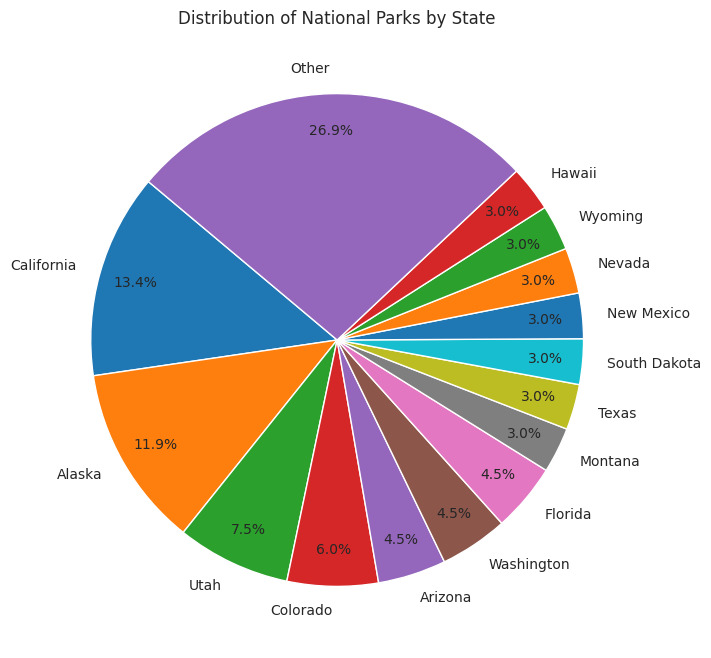

In [42]:
park_counts = national_parks_df['State'].value_counts()

threshold = 2.9
small_states = park_counts[park_counts / park_counts.sum() * 100 < threshold].index
park_counts_filtered = park_counts.drop(small_states)
others_count = park_counts.loc[small_states].sum()
park_counts_filtered['Other'] = others_count

plt.figure(figsize=(8, 8))
sns.set_style("whitegrid")
plt.pie(park_counts_filtered, labels=park_counts_filtered.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.title('Distribution of National Parks by State')

plt.show()

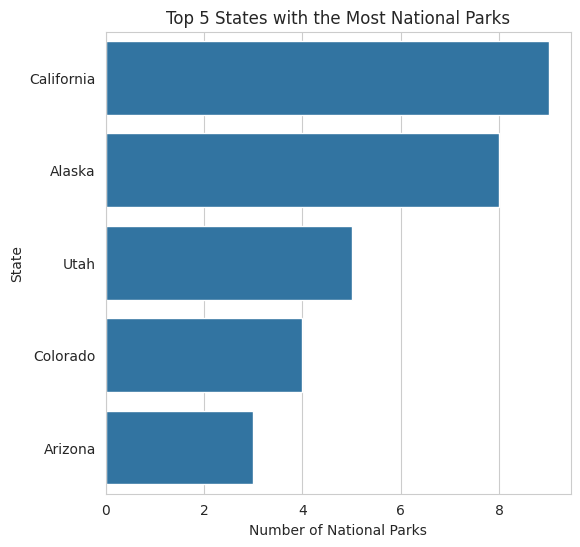

In [43]:
state_counts = national_parks_df['State'].value_counts()

top_5_states = state_counts.head(5)

plt.figure(figsize=(6,6))
sns.set_style("whitegrid")
sns.barplot(x=top_5_states.values, y=top_5_states.index)
plt.title('Top 5 States with the Most National Parks')
plt.xlabel('Number of National Parks')
plt.ylabel('State')
plt.show()